
<div class="alert alert-block alert-info">
   <h2 align="center"> <center><b> Reinforcement Learning Assignment 6 - Actor Critic part 1 </b></center></h2>

<br>
<center><font size="3">This notebook is part of the teaching material for ELEC-E8125</font></center>
<center><font size="3">Aalto University</font></center>
</div>


<a id='TOC'></a>

<div class="alert alert-block alert-success">
    
# Table of contents
* <a href='#1.'> 1. Introduction </a>
* <a href='#1.1'> 1.1 Learning Objectives </a>
* <a href='#1.2'> 1.2 Code Structure & Files </a>
* <a href='#2.'> 2. Policy Gradient with a Critic </a>
* <a href='#3.'> 3. Submitting </a>
* <a href='#3.1'> 3.1 Feedback </a>
* <a href='#4.'> References</a>

<a href='#T1'><b>Student Task 1.</b> Implementing PG with critic (20 points)</a>\
<a href='#Q1'><b>Student Question 1.1</b> Relationship between actor-critic and REINFORCE with baseline (10 points)</a>\
<a href='#Q2'><b>Student Question 1.2</b> Advantage (5 points)  </a>\
<a href='#Q3'><b>Student Question 1.3</b> Bias and Variance Analysis (10 points) </a>\
<a href='#Q4'><b>Student Question 1.4</b> Controlling bias-variance tradeoff (10 points)</a>
    
**Total Points:** 55

**Estimated runtime of all the cells:** 1 hour

# 1. Introduction <a id='1.'></a>

In this assignment, we will implement an actor-critic reinforcement learning algorithm which combines elements of both value-based methods (critic) and policy-based methods (actor) to improve learning and stability in the **InvertedPendulum-v4**  environment.

## 1.1 Task environments: <a id='1.1'></a>

In this exercise, we will focus on InvertedPendulum-v4 tasks:
- InvertedPendulum-v4(https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/): This environment is similar to the cartpole environment but now powered by the Mujoco physics simulator - allowing for more complex experiments (such as varying the effects of gravity). This environment involves a cart that moves horizontally, with a pole fixed on the cart at one end and the other end of the pole moving freely. The cart can be pushed left or right. The goal is to move the pole such that it is vertically above the cart pointing straight up by applying horizontal forces on the cart.
<figure style="text-align: center">
    <img src="imgs/InvertedPendulum.png" width="300"/>
    <figcaption style="text-align: center">  Figure 1: The InvertedPendulum-v4 environment. </figcaption>
</figure>

## 1.2 Learning Objectives: <a id='1.1'></a>

- Understand the idea of actor-critic algorithms
- Understand the limits and use cases of actor-critics

## 1.3 Code Structure & Files <a id='1.2'></a>

```ex6_PG_AC.ipynb``` is the file needed to be modified for this part of the assignment.  

<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER PART IN ```ex6_DDPG.ipynb```** </span>

```
├───cfg                            # Config files for environments
├───imgs                           # Images used in notebook
├───results
│   └───HalfCheetah-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*HalfCheetah-v4_params.pt    # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*ddpg.png               # Contains training performance plot
│   └───InvertedPendulum-v4
│   │   ├───logging                
│   │   │    └───logging.pkl        # Contains logged data
│   │   ├───model              
│   │   │    └───*InvertedPendulum-v4_params.pt      # Contains trained model
│   │   └───video                   # Videos saved
│   │   └───*pg_ac.png              # Contains training performance plot
│   ex6_DDPG.ipynb                  # 2nd assignment file containing tasks <---------
│   ex6_PG_AC.ipynb                 # 1st assignment file containing tasks <---------This task
│   train.py                        # Contains train and test functions 
│   utils.py                        # Contains useful functions 
└───buffer.py                       # Contains buffer functions
```

## 1.4 Execution time <a id='1.4'></a>

The training of Actor-Critic may take more than 30 mins depending on the server load. If you have problems with the training time, you can train locally.

## Warnings:

- Don’t copy and paste cells within a notebook. This will mess up the tracking metadata and prevent autograding from working.
- Only add new cells using the '+' button in the upper toolbar and do not split cells.
- Be cautious about things such as copying the whole notebook to Colab to work on it. This has sometimes resulted in removing all notebook metadata, making autograding impossible.


# 2. Policy Gradient with a Critic <a id='2.'></a>

<a id='T1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Task 1.</b> Implement policy gradient (PG) with critic (20 points) </h3> 

Revisit the policy gradient solution for the InvertedPendulum from Exercise 5 with learned sigma if needed. Implement the actor-critic algorithm below. Perform TD(0) updates at the end of each episode. You can check the training performance plot in the result folder after running the plot cell. Take Figure 2 as a reference training plot. 
    
**Hint:** Check out the PyTorch tutorial from [here](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) to see how to calculate the $A_\theta \Delta_\theta \log \pi_\theta(a_i|s_i)$ term using the ```detach()``` function. 

<figure style="text-align: center">
<img src="imgs/pg_ac.png" width="400px">
<figcaption style="text-align: center"> Figure 2: Training plot of the policy gradient with a critic.
</figcaption>
</figure>
     
**Complete the all the unfinished implementation in `PG` class (marked with ```TODOs```)**. 
    
1. **Policy Network**: Finish the `__init__(self, state_dim, action_dim)` function and `forward(self, state)` function within the `Policy` class
2. **Agent Update Function**: Finish the `update(self, )` function within the `PG` class
3. **Get Action Method**: Finish the `get_action(self, observation, evaluation=False)` function within the `PG` class.
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>


In [24]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
from pathlib import Path
from IPython.display import Video

import torch, yaml
from torch import nn
import torch.nn.functional as F
from torch.distributions import Normal

import train as t
import utils as u

device = 'cpu'

In [3]:
# Actor-critic agent
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Policy(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        # Create a neural network and use it for the mean of the policy.
        # The size of the neural network here has been chosen such that 
        # it is not too big but should perform well in the tasks we want to look at.
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(state_dim, 64)), nn.Tanh(),
            layer_init(nn.Linear(64, 64)), nn.Tanh(),
            layer_init(nn.Linear(64, action_dim), std=0.01),
        )
        
        """
        # TODO: Implement actor_logstd as a learnable parameter
        # Use log of std to make sure std (standard deviation) of the policy
        # doesn't become negative during training
        """
        self.actor_logstd = torch.nn.Parameter(torch.zeros(action_dim, device=device))
        
    def forward(self, state):
        # Get mean of a Normal distribution (the output of the neural network)
        action_mean = self.actor_mean(state)

        # Make sure action_logstd matches dimensions of action_mean
        action_logstd = self.actor_logstd.expand_as(action_mean)

        # Exponentiate the log std to get actual std
        action_std = torch.exp(action_logstd)
        
        """
        # TODO: Create a Normal distribution with mean of 'action_mean' & standard deviation of 'action_logstd' 
        # and return the distribution. You should be using the torch.distributions.Normal class to create the distribution.
        """
        probs = Normal(action_mean, action_std)

        return probs

    
class Value(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.value = nn.Sequential(
            layer_init(nn.Linear(state_dim, 64)), nn.Tanh(),
            layer_init(nn.Linear(64, 64)), nn.Tanh(),
            layer_init(nn.Linear(64, 1)))
    
    def forward(self, x):
        return self.value(x).squeeze(1) # output shape [batch,]


class PG(object):
    def __init__(self, state_dim, action_dim, lr, gamma):
        self.name = 'pg'
        self.policy = Policy(state_dim, action_dim).to(device)
        self.value = Value(state_dim).to(device)
        self.optimizer = torch.optim.Adam(list(self.policy.parameters()) + list(self.value.parameters()), 
                                         lr=float(lr),)

        self.gamma = gamma

        # a simple buffer
        self.states = []
        self.action_probs = []
        self.rewards = []
        self.dones = []
        self.next_states = []

    '''
    TODO: Task 1
    # Complete the following 4 functions
    # Hints: 1. calculate the target values as well as the MSE loss between the predicted value and the target values
    #        2. calculate the policy loss (similar to ex5) with advantage calculated from the value function. Normalise
    #           the advantage to zero mean and unit variance.
    #        3. Use mean to calculate the actor (policy) loss ;)
    #           - https://discuss.pytorch.org/t/loss-reduction-sum-vs-mean-when-to-use-each/115641/2
    '''
    
    # 1. Calculate the target values, you should not modify the gradient of the variables
    def calculate_target_values(self, rewards, next_states, dones):
        ########## Your code starts here. ##########
        with torch.no_grad():
            next_values = self.value(next_states)
            target_values = rewards + self.gamma * (1 - dones) * next_values
        ########## Your code ends here. ##########
        return target_values

    # 2. Calculate the critic loss
    def calculate_critic_loss(self, values, target_values):
        ########## Your code starts here. ##########
        critic_loss = F.mse_loss(values, target_values)
        ########## Your code ends here. ##########
        return critic_loss
    
    # 3. Advantage estimation, you should not modify the gradient of the variables
    def calculate_advantage(self, values, target_values):
        ########## Your code starts here. ##########
        with torch.no_grad():
            advantage = target_values - values
            advantage = (advantage - advantage.mean()) / advantage.std()
        ########## Your code ends here. ##########
        return advantage
    
    # 4. Calculate the actor (policy) loss 
    def calculate_actor_loss(self, action_probs, advantage):
        ########## Your code starts here. ##########
        weighted_probs = action_probs * advantage
        actor_loss = -weighted_probs.mean()
        ########## Your code ends here. ##########
        return actor_loss

    def update(self,):
        action_probs = torch.stack(self.action_probs, dim=0) \
                .to(device).squeeze(-1)
        rewards = torch.stack(self.rewards, dim=0).to(device).squeeze(-1)
        states = torch.stack(self.states, dim=0).to(device).squeeze(-1)
        next_states = torch.stack(self.next_states, dim=0).to(device).squeeze(-1)
        dones = torch.stack(self.dones, dim=0).to(device).squeeze(-1)
        # clear buffer
        self.states, self.action_probs, self.rewards, self.dones, self.next_states = [], [], [], [], []

        """
        # TODO: Compute the current state value estimates using the value function network
        """
        values = self.value(states)
        
        target_values = self.calculate_target_values(rewards, next_states, dones)        
        critic_loss = self.calculate_critic_loss(values, target_values)        
        advantage = self.calculate_advantage(values, target_values)
        actor_loss = self.calculate_actor_loss(action_probs, advantage)

        """
        # TODO: Compute the gradients of the joint loss w.r.t network parameters
        """
        loss = critic_loss + actor_loss
        loss.backward()

        # Update network parameters using self.optimizer and zero gradients 
        self.optimizer.step()  
        nn.utils.clip_grad_norm_(list(self.policy.parameters())+ list(self.value.parameters()), 1.0)
        self.optimizer.zero_grad() 

        return {}

    def get_action(self, observation, evaluation=False):
        """Return action (np.ndarray) and logprob (torch.Tensor) of this action."""
        if observation.ndim == 1: observation = observation[None] # add the batch dimension
        x = torch.from_numpy(observation).float().to(device)
        
        '''
        # TODO: Task 1
        # Hints: 1. the self.policy returns a normal distribution, check the PyTorch documentation to see 
        #           how to calculate the log_prob of an action and how to sample.
        #        2. if evaluating the policy, return policy mean, otherwise, return a sample
        #        3. the returned action and the act_logprob should be torch.Tensors.
        #           Please always make sure the shape of variables is as you expected.
        '''
        ########## Your code starts here. ##########
        dist = self.policy(x)
        if evaluation:
            action = dist.mean.squeeze()
        else:
            action = dist.sample().squeeze()
        
        # compute the log probability of the action
        act_logprob = dist.log_prob(action).sum(dim=-1).squeeze()
        ########## Your code ends here. ###########

        return action, act_logprob

    def record(self, observation, action_prob, next_observation, reward, done):
        self.states.append(torch.tensor(observation, dtype=torch.float32))
        self.action_probs.append(action_prob)
        self.rewards.append(torch.tensor([reward], dtype=torch.float32))
        self.dones.append(torch.tensor([done], dtype=torch.float32))
        self.next_states.append(torch.tensor(next_observation, dtype=torch.float32))

    def load(self, filepath):
        d = torch.load(filepath)
        self.policy.load_state_dict(d['policy'])
        self.value.load_state_dict(d['value'])
    
    def save(self, filepath):
        torch.save({
            'policy': self.policy.state_dict(),
            'value': self.value.state_dict(),
        }, filepath)

In [4]:
# Test Policy
def test_policy_class():
    policy = Policy(4, 1)
    x = torch.Tensor((1.,2.,3.,4.)).reshape((1,4))
    assert isinstance( policy.forward(x),Normal)
    assert policy.actor_logstd.requires_grad

test_policy_class()

In [5]:
#Test get_action method
def test_get_action_1():
    cfg_path=Path().cwd()/'cfg'/'pg_ac.yaml'
    cfg_args=dict(save_video=False,testing=False,seed=43)
    env, cfg = t.setup(cfg_path, cfg_args=cfg_args)
    agent = PG(cfg.state_shape[0], cfg.action_dim, cfg.lr, cfg.gamma)
    obs = np.array([ 0.00978977, -0.00972236, -0.00706408,  0.00517535])
    action = -2.0871510059805587e-05
    assert np.allclose(agent.get_action(obs,True)[0].item(),action,atol=1e-03)

    agent2 = PG(cfg.state_shape[0], cfg.action_dim, cfg.lr, cfg.gamma)
    assert tuple(agent2.get_action(obs,True)[1].shape) == ()

test_get_action_1()

Numpy/Torch/Random Seed:  43


In [6]:
def test_update_function_1():
    cfg_path=Path().cwd()/'cfg'/'pg_ac.yaml'
    cfg_args=dict(save_video=False,testing=False,seed=43)
    env, cfg = t.setup(cfg_path, cfg_args=cfg_args)
    agent = PG(4, cfg.action_dim, cfg.lr, cfg.gamma)

    rewards = torch.tensor([1., 1., 1., 1.])
    action_probs = torch.tensor([-0.9286, -1.1687, -1.2360, -1.7127])
    next_states = torch.tensor([[-0.0079,  0.0071, -0.1703,  0.4061],
                                [-0.0274,  0.0524, -0.8029,  1.8464],
                                [-0.0633,  0.1342, -0.9942,  2.2525],
                                [-0.0931,  0.2017, -0.4978,  1.1568]])
    dones = torch.tensor([0., 0., 0., 1.])
    states = torch.tensor([[-4.6008e-03, -1.0801e-03,  7.1437e-03, -1.4543e-03],
                           [-7.8743e-03,  7.0946e-03, -1.7034e-01,  4.0608e-01],
                           [-2.7371e-02,  5.2385e-02, -8.0292e-01,  1.8464e+00],
                           [-6.3307e-02,  1.3419e-01, -9.9422e-01,  2.2525e+00]])
    values = torch.tensor([-0.0013, -0.0137, -0.0187, -0.0289])

    target_values = agent.calculate_target_values(rewards, next_states, dones)        
    critic_loss = agent.calculate_critic_loss(values, target_values)        
    adv = agent.calculate_advantage(values, target_values)
    actor_loss = agent.calculate_actor_loss(action_probs, adv)

    assert torch.allclose(target_values, torch.tensor([0.9864, 0.9815, 0.9714, 1.0000]), atol = 0.001)
    assert torch.allclose(critic_loss, torch.tensor(1.0012), atol = 0.001)
    assert torch.allclose(adv, torch.tensor([-0.6645, -0.2767, -0.5391,  1.4803]), atol = 0.001)
    assert torch.allclose(actor_loss, torch.tensor(0.2321), atol = 0.001)

test_update_function_1()

Numpy/Torch/Random Seed:  43


In [7]:
%%capture --no-stdout
"TEST"

In [8]:
%%capture --no-stdout
"TEST"

In [9]:
# init agent
with open(Path().cwd()/'cfg'/'pg_ac.yaml', 'r') as f:
    cfg = u.Struct(**yaml.safe_load(f))
    
agent = PG(cfg.state_shape[0], cfg.action_dim, cfg.lr, cfg.gamma)

In [10]:
if not skip_training:
    t.train(agent, cfg_path=Path().cwd()/'cfg'/'pg_ac.yaml', cfg_args={})

Numpy/Torch/Random Seed:  837
{'episode': 0, 'timesteps': 5, 'ep_reward': 5.0}
{'episode': 50, 'timesteps': 4, 'ep_reward': 4.0}
{'episode': 100, 'timesteps': 10, 'ep_reward': 10.0}
{'episode': 150, 'timesteps': 5, 'ep_reward': 5.0}
{'episode': 200, 'timesteps': 10, 'ep_reward': 10.0}
{'episode': 250, 'timesteps': 29, 'ep_reward': 29.0}
{'episode': 300, 'timesteps': 27, 'ep_reward': 27.0}
{'episode': 350, 'timesteps': 63, 'ep_reward': 63.0}
{'episode': 400, 'timesteps': 26, 'ep_reward': 26.0}
{'episode': 450, 'timesteps': 75, 'ep_reward': 75.0}
{'episode': 500, 'timesteps': 180, 'ep_reward': 180.0}
{'episode': 550, 'timesteps': 65, 'ep_reward': 65.0}
{'episode': 600, 'timesteps': 184, 'ep_reward': 184.0}
{'episode': 650, 'timesteps': 95, 'ep_reward': 95.0}
{'episode': 700, 'timesteps': 111, 'ep_reward': 111.0}
{'episode': 750, 'timesteps': 149, 'ep_reward': 149.0}
{'episode': 800, 'timesteps': 302, 'ep_reward': 302.0}
{'episode': 850, 'timesteps': 119, 'ep_reward': 119.0}
{'episode': 9

Numpy/Torch/Random Seed:  625


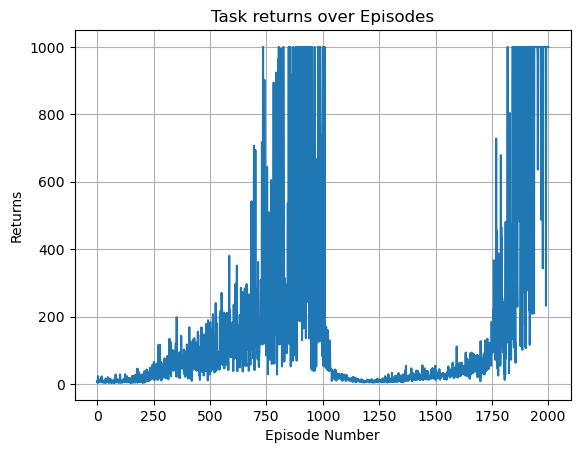

In [11]:
if not skip_training:
    t.plot(cfg_path=Path().cwd()/'cfg'/'pg_ac.yaml',)

In [12]:
if not skip_training:
    t.test(agent, cfg_path=Path().cwd()/'cfg'/'pg_ac.yaml', cfg_args=dict(save_video=True,testing=True))

Numpy/Torch/Random Seed:  820
Loading model from /notebooks/rl2024/ex6/results/InvertedPendulum-v4/model/InvertedPendulum-v4_params.pt ...
Testing ...
Moviepy - Building video /notebooks/rl2024/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-0.mp4.
Moviepy - Writing video /notebooks/rl2024/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2024/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-0.mp4
Ep0: Test ep_reward is 1000.0
Ep1: Test ep_reward is 1000.0
Ep2: Test ep_reward is 1000.0
Ep3: Test ep_reward is 1000.0
Ep4: Test ep_reward is 1000.0
Ep5: Test ep_reward is 1000.0
Ep6: Test ep_reward is 1000.0
Ep7: Test ep_reward is 1000.0
Ep8: Test ep_reward is 1000.0
Moviepy - Building video /notebooks/rl2024/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-9.mp4.
Moviepy - Writing video /notebooks/rl2024/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /notebooks/rl2024/ex6/results/InvertedPendulum-v4/video/test/ex6-episode-9.mp4
Ep9: Test ep_reward is 1000.0
Average test reward: 1000.0


In [13]:
if not skip_training:
    video = Video(Path().cwd()/'results'/'InvertedPendulum-v4'/'video'/'test'/'ex6-episode-0.mp4',
    embed=True, html_attributes="loop autoplay") # Set html_attributes="controls" for video control
    display(video)

In [14]:
%%capture --no-stdout
"TEST"

<a id='Q1'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.1</b> Relationship between actor-critic and REINFORCE with baseline (10 points) </h3> 

What is the relationship between actor-critic and REINFORCE with baseline?
            
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

<h5><b>Options</b></h5>

1. Both actor-critic and REINFORCE use boostrapping to update their parameters. 
2. Both methods use Monte-Carlo estimates for updating their parameters.
3. The baseline in REINFORCE is the state value function for actor-critic.
4. Both methods require full-trajectories before they can update their parameters.
5. Both methods can update their parameters during each timestep.
6. Actor-critic uses bootstrapping to update its parameters while REINFORCE does not.

Select the **two** most appropriate answers. Selecting more than 2 answers results in zero points from this task.

In [18]:
sq1_1 = [3, 6] # Select the most approapriate answers

The cells below are used for autograding.

In [19]:
assert 1 <= len(sq1_1) <= 2
assert set(sq1_1) < set(range(1, 7))

<a id='Q2'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.2</b> Advantage (5 points) </h3> 

How can the value of advantage be intuitively interpreted? (Your answer should not be longer than 10 sentences).
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

The advantage function tells us how much better or worse an action is compared to the average action at this state. If the advantage is positive, that action was better than expected, and vice versa.

<a id='Q3'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.3</b> Bias and Variance Analysis (10 points) </h3> 

How does the implemented actor-critic method compare to REINFORCE in terms of bias and variance of the policy gradient estimation? Explain your answer. (Your answer should not be longer than 10 sentences).
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

The actor-critic method reduces the variance of policy gradient estimation compared to REINFORCE by using a learned value  
function to estimate the expected return, rather than relying solely on sampled returns. This stabilizes the updates by  
providing a more accurate estimate of future rewards. However, this comes at the cost of introducing bias because the value  
function approximation might be imperfect. In contrast, REINFORCE is unbiased since it directly uses actual returns, but it  
suffers from high variance, leading to slow and unstable learning.

<a id='Q4'></a>
<div class=" alert alert-warning">
    <h3><b>Student Question 1.4</b> Controlling bias-variance tradeoff (10 points) </h3> 

How could the bias-variance tradeoff in actor-critic be controlled? (Your answer should not be longer than 10 sentences).
    
🔝	<a href='#TOC'><b>Table of Contents</b></a>
</div>

The bias-variance tradeoff could be controlled by adjusting the accuracy of the critic’s value function. A better  
critic can reduce bias, but risks higher variance in the updates. On the other hand, a simpler value function  
decreases variance, but increases bias. Alternatively, something like different learning rates for actor and critic  
could help control the tradeoff.


# 3. Submitting <a id='3.'></a>
Ensure all tasks and questions (in ```ex6_DDPG.ipynb``` and ```ex6_PG_AC.ipynb```) are answered and the necessary plots are saved in the appropriate locations. The relevant plots and files needed to be submitted for this assignment are:


- Training performance plots:
  - `pg_ac.png`: Training performance plots in terms of episode and episodic reward
<br>

  
- Model files:
  - `InvertedPendulum-v4_params.pt`: Trained model


Ensure the model files and plots are saved in correct paths:
- ```results/InvertedPendulum-v4/pg_ac.png``` Training result
- ```results/InvertedPendulum-v4/model/InvertedPendulum-v4_params.pt``` Training Model


<span style="color:red"> **# IMPORTANT: DO NOT FORGET ANOTHER TASK IN ```ex6_DDPG.ipynb```** </span>

In [25]:
# Make sure that skip training is set to True before submission
assert skip_training == True

## 3.1 Feedback <a id='3.1'></a>

In order to help the staff of the course as well as the forthcoming students, it would be great if you could answer to the following questions in your submission:

1) How much time did you spend solving this exercise? (change the ```hrs``` variable below to a floating point number representing the number of hours taken e.g. 5.43)

In [23]:
hrs = 5

2) Difficulty of each task/question from 1-5 (int or float)

In [22]:
T1 = 4   # Implementing DDPG (20 points)
Q1 = 4   # Question 1.1 Relationship between actor-critic and REINFORCE with baseline (10 points)
Q2 = 4   # Question 1.2 Advantage (5 points)
Q3 = 4   # Question 1.3 Bias and Variance Analysis (10 points)
Q4 = 4   # Question 1.4 Controlling bias-variance tradeoff (10 points)

3) How well did you understand the content of the task/question from 1-5? (int or float)

In [21]:
T1 = 4   # Implementing DDPG (20 points)
Q1 = 3   # Question 1.1 Relationship between actor-critic and REINFORCE with baseline (10 points)
Q2 = 3   # Question 1.2 Advantage (5 points)
Q3 = 3   # Question 1.3 Bias and Variance Analysis (10 points)
Q4 = 3   # Question 1.4 Controlling bias-variance tradeoff (10 points)

4) General feedback. Consider questions like:

    - Did the content of the lecture relate well with the assignment?
    - To what extent did you find the material to be potentially useful for your research and studies?
    
Please share any additional feedback, suggestions, or comments you have about the lecture, assignment, or course content. Your input is valuable in helping us improve the learning experience.

DOUBLE CLICK HERE TO EDIT, CLEAR THIS TEXT AND ANSWER HERE

# References <a id='4.'></a>
Please use the following section to record references.